In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, layers, models
import pickle

In [5]:
# Check that TF version (2.1.0 - 2.3.2 should be fine)
print(tf.__version__)

1.14.0


# Code Index

* 1) [CNN](#cnn)
  * 1.1 [Overfitting](#overfitting)
  * 1.2 [Improvements](#improvements)
      * a) [Dropout at input](#input_dropout)
      * b) [Multiple Dropouts](#multiple_dropouts)

* 2) [Autoencoders](#autoencoders)
    * 2.1 [Linear AE](#linear_ae)
    * 2.2 [Convolutional AE](#convolutional_ae)
    * 2.3 [Machine anomaly detection](#anomaly_detection)

# For turn-in move all answers to questions and requested plots to top of notebook or this will not be graded. Also make a final clean run of your code so the cells execute in order.

### Points awarded for correct working models, questions, and plots.

[+10 per model correct and working -5 for failure on either]

**1.1 Answer the following questions:**
1.   Explain the indication of overfitting and how this occurs (provide plot supporting your answer)? [+4 answer, +4 plot, +2 answer and plot agree]

2.   Explain how overfit can hinder performance of a model when deployed. [+6 answer]

3.   Name two ways to avoid this. [+2 answer, +2 answer]

Answer 1.1:

1) Overfitting occurs when the model starts specifically learning the data that it is training upon and is not able to generalize beyond the training data. In such cases it has an increasing training data accuracy while its test data accuracy or loss decreases. Same goes for loss, where the training data loss keeps on decreasing while test data loss remains steady or increases as we keep training the model.

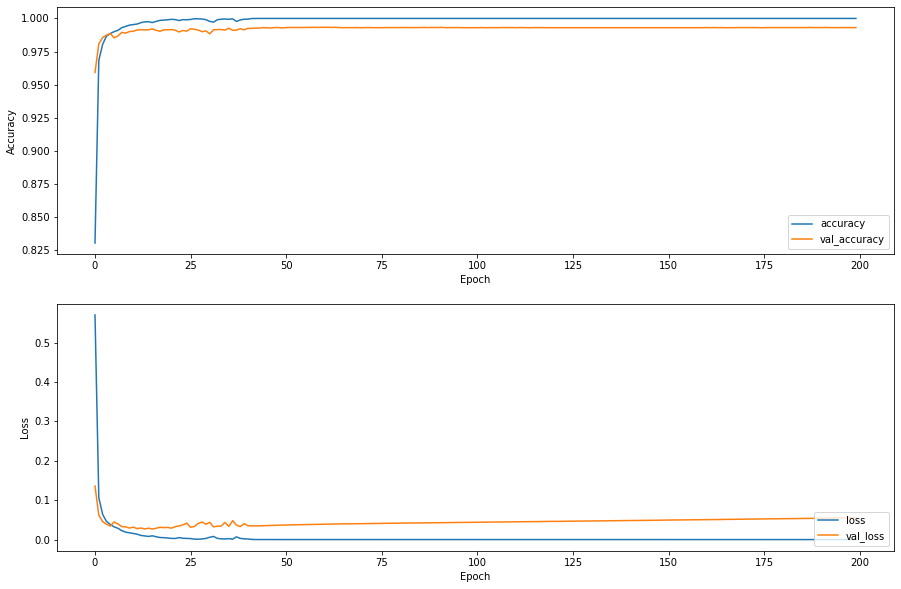

In [10]:
#DO NOT RUN THIS CELL
# Here, we can clearly see that the loss and val_loss are straying apart indicating that the model is probably overfitting.

2) Overfitted models are especially troublesome when the they're deployed because they're will only be able to make "predictions" based on the specialized set of data that they learned on and would not be able to work on unseen data properly as they have not learned the underlying pattern within the data but just the data itself. Thus, since they lack generalization, they would perform poorly in real world applications. 

3) Ways to avoid overfitting:
* Dropout, randomly remove some of the learned parameters while training to not let the model get biased upon any particular set of them.
* Train on more data. If possible to accrue more data for training, then utilizing more data for training helps.

**1.2 Answer the following question:** 
 1.   Explain how dropout affected your loss (provide plot supporting your answer). [+5 answer, +5 plot]

Answer 1.2:


1) By adding dropout, the model is now trained such that it does not learn interdependent set of feature weights allowing it to generalize its learning to pick up on underlying trends in the data rather. This allows the model to perform better on unseen data. Thus, by judiciously adding dropout we are able to see similar loss in training and test data.

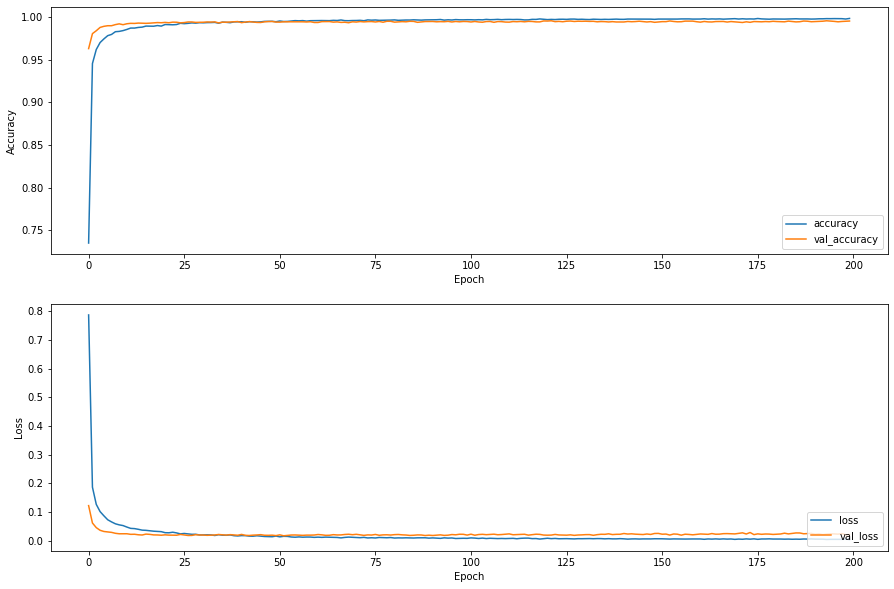

In [29]:
#DO NOT RUN THIS CELL
# Here the loss and val_loss, and accuracy and val_accuracy do not diverge.

**Bonus Answer the following question:**
    
  1. Considering that encoder and decoder can be constructed as separate components, trained as a single unit, and then separated for use . What uses can you brainstorm?  [+5 bonus makeup points]

Bonus question answer: 


* Encoder part can be used to reduce the dimensonality of linear and nonlinear data, hence it can be used in place of PCA.
* Decoder part can be used for image generation using only few parameters. 

**2.1 Linear AE points for constructed model, no questions here.**

**2.2 Convolutional AE points for constructed model, no questions here.**

**2.3 Report histogram plot, mean and std. dev. of normal data, and confusion matrix for 2 standard deviations as results. Discuss your loss plot.** [+10 for greater than 75 TP, +10 all else]

Answer 2.3:


* **Choice of layers**: Simple Autoencoder with stacked conv and maxpool layers has been used. A dropout layer has been included in encoder part to not let encoder give importance to any particular data feature. (3,3) filters with 1 stride have been use after applying uniform padding at each layer.
    
    
* **Layer sizing**: Feature maps of each convolutional layer are as follows 16->8->8->16->8. 
    * Conv2D     $\;\;\;\;$ 64, 316, 16
    * MaxPooling 32, 158, 16
    * Dropout    $\;\;\;\;$ 32, 158, 16
    * Conv2D     $\;\;\;\;$ 32, 158, 8       
    * MaxPooling 16, 79, 8           
    * Conv2D     $\;\;\;\;$ 16, 79, 8         
    * UpSampling 32, 158, 8
    * Conv2D     $\;\;\;\;$ 32, 158, 16
    * UpSampling 64, 316, 16
    * Conv2D     $\;\;\;\;$ 64, 316, 8


* **Choice of loss function**: MSE has been chosen.


* **Choice of nonlinearity**: Relu has been used in all the layers. 


* **Shape of data input and why**: Input data has been transformed from (8, 64, 313) to (64, 316, 8). Firstly padding was added so that after maxpooling each dimension is evenly reduced till 2 levels. Then, data was transposed to provide the model's layers with correct number of channels (8).


* **Batch sizing**: Default (32). Large batch size was not used to allow the model to learn faster and get more gradient updates per epoch.


* **Hyperparameter**: 
    * 30% Dropout was added to prevent encoder from overfitting on certain features. 
    * ReLu activation function was used in each layer. 
    * Number of epochs = 200

***Reminder: Achieve better than 75 anomalies***

In [3]:
#Import dataset and normalize to [0,1]
fashion_mnist = tf.keras.datasets.mnist
(data_train, labels_train), (data_test, labels_test) = fashion_mnist.load_data()

In [4]:
#Normalize
data_train = data_train / 255.0
data_test = data_test / 255.0
print(data_train.shape)
print(data_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [5]:
#Reshape
data_train = data_train.reshape(60000, 28, 28, 1)
data_test = data_test.reshape(10000, 28, 28, 1)

In [6]:
#Create labels as one-hot vectors
labels_train = tf.keras.utils.to_categorical(labels_train, num_classes=10)
labels_test = tf.keras.utils.to_categorical(labels_test, num_classes=10)

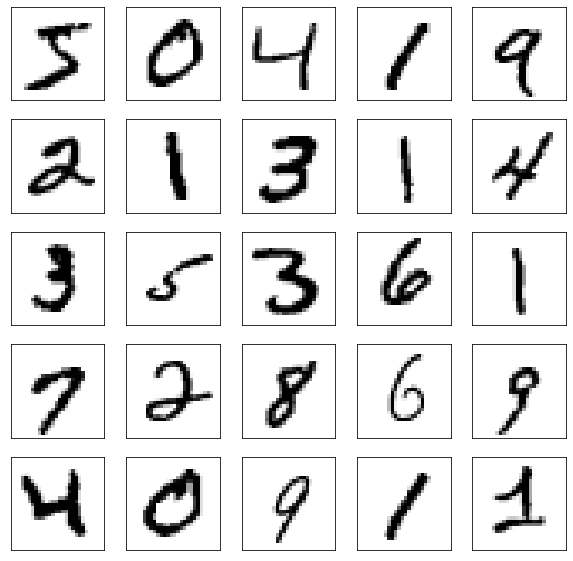

In [11]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data_train[i], cmap=plt.cm.binary)
    #plt.xlabel(class_names[labels_train[i][0]])
plt.show()

# Section 1 - CNN's
<a id='cnn'></a>

Fill in the model:
* Input: 28x28x1 grayscale image (1 specifies single channel grayscale).
* 1st hidden: 2D convolutional layer with 256 feature maps and 3x3 filters.
* 2nd hidden: A 2x2 maxpool layer.
* 3rd hidden: 2D convolutional layer with 128 feature maps and 3x3 filters.
* 4th hidden: A 2x2 maxpool layer.
* 5th hidden: Flatten layer to map 2D to 1D vector.
* 6th hidden: Dense layer of 100 perceptrons.
* 7th hidden: Dense layer of 100 perceptrons.
* Output: 10 perceptrons for classification.
<br>**Activations, bias, loss function, and optimizer are your choice.
<br>  Train for 200 epochs**

## 1.1 Overfitting 
<a id='overfitting'></a>

In [7]:
#Create and train model architecture
def CNN_overfit():

    #Easiest way to build model in Keras is using Squential. 
    #It allows model to be build layer by layer as we will do here
    
    #### Fill in Model ####
    
    model = models.Sequential()
    model.add(layers.Conv2D(256, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(10))
    model.add(tf.keras.layers.Softmax())
    
    return model

#Compile and train the model
CNN_overfit = CNN_overfit()
CNN_overfit.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
                    optimizer='adam', 
                    metrics=['accuracy'])
history_overfit = CNN_overfit.fit(data_train, labels_train, 
                                  validation_data=(data_test, labels_test), 
                                  epochs=200, batch_size=1000, shuffle=True)
scores = CNN_overfit.evaluate(data_test, labels_test)
print("Accuracy: %.2f%%" %(scores[1]*100))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 6s 104us/sample - loss: 0.5706 - acc: 0.8303 - val_loss: 0.1360 - val_acc: 0.9591
Epoch 2/200
60000/60000 [==============================] - 4s 66us/sample - loss: 0.1064 - acc: 0.9685 - val_loss: 0.0620 - val_acc: 0.9808
Epoch 3/200
60000/60000 [==============================] - 4s 66us/sample - loss: 0.0640 - acc: 0.9804 - val_loss: 0.0458 - val_acc: 0.9855
Epoch 4/200
60000/60000 [==============================] - 5s 75us/sample - loss: 0.0461 - acc: 0.9867 - val_loss: 0.0389 - val_acc: 0.9874
Epoch 5/200
60000/60000 [==============================] - 4s 74us/sample - loss: 0.0384 - acc: 0.9886 - val_loss: 0.0343 - val_acc: 0.9886
Epoch 6/200
60000/60000 [==============================] - 4s 72us/sample - loss: 0.0322 - acc: 0.9900 - val_loss: 0.0448 - val_acc

Epoch 56/200
60000/60000 [==============================] - 4s 70us/sample - loss: 1.5735e-05 - acc: 1.0000 - val_loss: 0.0381 - val_acc: 0.9932
Epoch 57/200
60000/60000 [==============================] - 4s 71us/sample - loss: 1.4638e-05 - acc: 1.0000 - val_loss: 0.0383 - val_acc: 0.9932
Epoch 58/200
60000/60000 [==============================] - 4s 69us/sample - loss: 1.3798e-05 - acc: 1.0000 - val_loss: 0.0386 - val_acc: 0.9933
Epoch 59/200
60000/60000 [==============================] - 4s 69us/sample - loss: 1.3249e-05 - acc: 1.0000 - val_loss: 0.0387 - val_acc: 0.9932
Epoch 60/200
60000/60000 [==============================] - 4s 69us/sample - loss: 1.2567e-05 - acc: 1.0000 - val_loss: 0.0388 - val_acc: 0.9933
Epoch 61/200
60000/60000 [==============================] - 4s 67us/sample - loss: 1.1777e-05 - acc: 1.0000 - val_loss: 0.0391 - val_acc: 0.9933
Epoch 62/200
60000/60000 [==============================] - 4s 65us/sample - loss: 1.1378e-05 - acc: 1.0000 - val_loss: 0.0391 - v

60000/60000 [==============================] - 4s 67us/sample - loss: 2.8588e-07 - acc: 1.0000 - val_loss: 0.0515 - val_acc: 0.9930
Epoch 169/200
60000/60000 [==============================] - 4s 65us/sample - loss: 2.7271e-07 - acc: 1.0000 - val_loss: 0.0517 - val_acc: 0.9931
Epoch 170/200
60000/60000 [==============================] - 4s 66us/sample - loss: 2.7409e-07 - acc: 1.0000 - val_loss: 0.0518 - val_acc: 0.9931
Epoch 171/200
60000/60000 [==============================] - 4s 70us/sample - loss: 2.5833e-07 - acc: 1.0000 - val_loss: 0.0518 - val_acc: 0.9931
Epoch 172/200
60000/60000 [==============================] - 4s 66us/sample - loss: 2.4893e-07 - acc: 1.0000 - val_loss: 0.0521 - val_acc: 0.9931
Epoch 173/200
60000/60000 [==============================] - 4s 69us/sample - loss: 2.4201e-07 - acc: 1.0000 - val_loss: 0.0520 - val_acc: 0.9931
Epoch 174/200
60000/60000 [==============================] - 4s 67us/sample - loss: 2.3412e-07 - acc: 1.0000 - val_loss: 0.0522 - val_acc:

In [9]:
# Information contained in history dict.
print(history_overfit.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


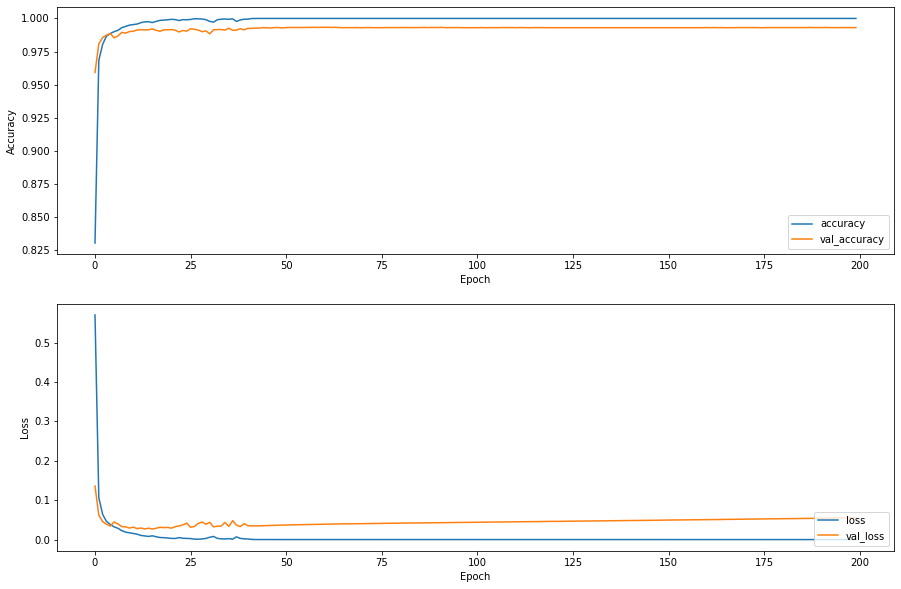

In [10]:
plt.figure(figsize=(15,10))
#Plot accuracy vs epoch
plt.subplot(211)

plt.plot(history_overfit.history['acc'], label='accuracy')
plt.plot(history_overfit.history['val_acc'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
#### Fill in plot ####

#Plot loss vs epoch
plt.subplot(212)
plt.plot(history_overfit.history['loss'], label='loss')
plt.plot(history_overfit.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
#### Fill in plot ####


In [11]:
test_loss, test_acc = CNN_overfit.evaluate(data_test, labels_test, verbose=2)

10000/10000 - 1s - loss: 0.0554 - acc: 0.9931


## 1.2 Improvements 
<a id='improvements'></a>

Using the network above, (1) insert a dropout of 30% between the input and first hidden layer. Run the model again and make note of the result. Next, (2 ) remove the dropout between input and hidden and add a dropout to each hidden layer except between softmax and output layer. Plot accuracy and loss only for (2). 

#### a) Insert a dropout of 30% between the input and first hidden layer
<a id='input_dropout'></a>

In [62]:
#Create and train model architecture
def CNN_dropout_hidden():
    
    #### Fill in model ####
    model = models.Sequential()
    model.add(layers.Input(shape=(28, 28, 1)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(10))
    model.add(layers.Softmax())
    
    return model

#Compile and train the model
CNN_dropout_hidden = CNN_dropout_hidden()
CNN_dropout_hidden.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
                           optimizer='adam', metrics=['accuracy'])
history_dropout_hidden = CNN_dropout_hidden.fit(data_train, labels_train, 
                                                validation_data=(data_test, labels_test), 
                                                epochs=200, batch_size=1000, shuffle=True)
scores_dropout_hidden = CNN_dropout_hidden.evaluate(data_test, labels_test)
print("Accuracy: %.2f%%" %(scores_dropout_hidden[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 5s 81us/sample - loss: 0.5427 - acc: 0.8279 - val_loss: 0.1692 - val_acc: 0.9581
Epoch 2/200
60000/60000 [==============================] - 4s 68us/sample - loss: 0.1215 - acc: 0.9636 - val_loss: 0.0949 - val_acc: 0.9755
Epoch 3/200
60000/60000 [==============================] - 4s 71us/sample - loss: 0.0833 - acc: 0.9744 - val_loss: 0.0781 - val_acc: 0.9813
Epoch 4/200
60000/60000 [==============================] - 4s 71us/sample - loss: 0.0653 - acc: 0.9793 - val_loss: 0.0668 - val_acc: 0.9849
Epoch 5/200
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0572 - acc: 0.9822 - val_loss: 0.0553 - val_acc: 0.9861
Epoch 6/200
60000/60000 [==============================] - 4s 69us/sample - loss: 0.0464 - acc: 0.9857 - val_loss: 0.0564 - val_acc: 0.9832
Epoch 7/200
60000/60000 [==============================] - 4s 69us/sample - loss: 0.0419 - acc: 0.9866 - val_l

Epoch 59/200
60000/60000 [==============================] - 4s 71us/sample - loss: 0.0050 - acc: 0.9983 - val_loss: 0.0288 - val_acc: 0.9907
Epoch 60/200
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0065 - acc: 0.9978 - val_loss: 0.0265 - val_acc: 0.9911
Epoch 61/200
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0055 - acc: 0.9980 - val_loss: 0.0313 - val_acc: 0.9901
Epoch 62/200
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0051 - acc: 0.9984 - val_loss: 0.0306 - val_acc: 0.9899
Epoch 63/200
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0050 - acc: 0.9984 - val_loss: 0.0289 - val_acc: 0.9911
Epoch 64/200
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0044 - acc: 0.9987 - val_loss: 0.0286 - val_acc: 0.9911
Epoch 65/200
60000/60000 [==============================] - 4s 67us/sample - loss: 0.0046 - acc: 0.9986 - val_loss: 0.0292 - val_acc: 0.9905
Epoch 66/200


Epoch 117/200
60000/60000 [==============================] - 4s 69us/sample - loss: 0.0029 - acc: 0.9991 - val_loss: 0.0314 - val_acc: 0.9904
Epoch 118/200
60000/60000 [==============================] - 4s 67us/sample - loss: 0.0021 - acc: 0.9993 - val_loss: 0.0276 - val_acc: 0.9911
Epoch 119/200
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0030 - acc: 0.9990 - val_loss: 0.0333 - val_acc: 0.9890
Epoch 120/200
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0036 - acc: 0.9987 - val_loss: 0.0368 - val_acc: 0.9876
Epoch 121/200
60000/60000 [==============================] - 4s 67us/sample - loss: 0.0037 - acc: 0.9988 - val_loss: 0.0325 - val_acc: 0.9897
Epoch 122/200
60000/60000 [==============================] - 4s 69us/sample - loss: 0.0024 - acc: 0.9992 - val_loss: 0.0323 - val_acc: 0.9896
Epoch 123/200
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0025 - acc: 0.9992 - val_loss: 0.0282 - val_acc: 0.9906
Epoch 

Epoch 175/200
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0011 - acc: 0.9997 - val_loss: 0.0293 - val_acc: 0.9919
Epoch 176/200
60000/60000 [==============================] - 4s 66us/sample - loss: 0.0025 - acc: 0.9993 - val_loss: 0.0363 - val_acc: 0.9891
Epoch 177/200
60000/60000 [==============================] - 4s 65us/sample - loss: 0.0014 - acc: 0.9996 - val_loss: 0.0305 - val_acc: 0.9911
Epoch 178/200
60000/60000 [==============================] - 4s 65us/sample - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0315 - val_acc: 0.9903
Epoch 179/200
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0015 - acc: 0.9994 - val_loss: 0.0332 - val_acc: 0.9896
Epoch 180/200
60000/60000 [==============================] - 4s 69us/sample - loss: 0.0012 - acc: 0.9996 - val_loss: 0.0423 - val_acc: 0.9879
Epoch 181/200
60000/60000 [==============================] - 4s 69us/sample - loss: 0.0028 - acc: 0.9992 - val_loss: 0.0365 - val_acc: 0.9885
Epoch 

CPU times: user 37.6 ms, sys: 5.78 ms, total: 43.4 ms
Wall time: 37.7 ms


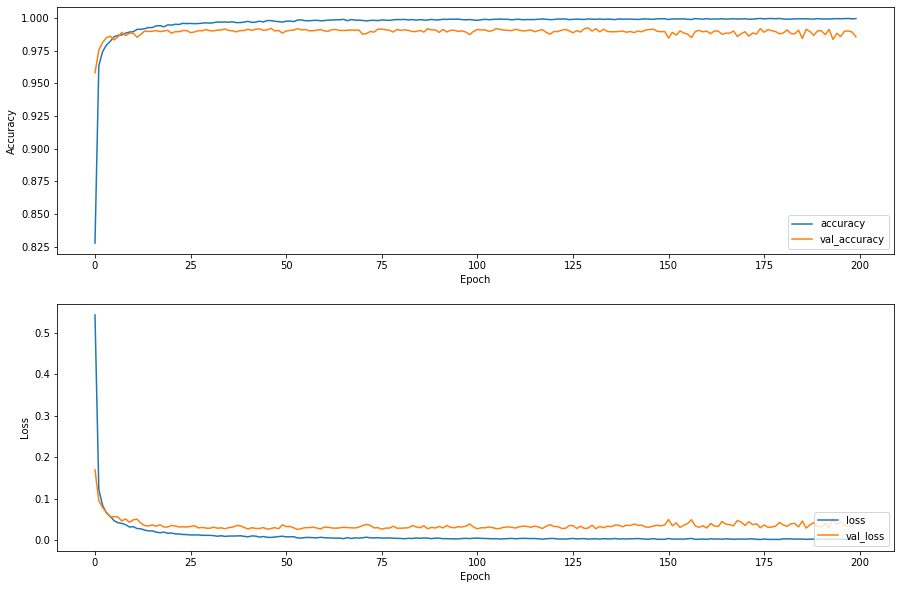

In [63]:
%%time

plt.figure(figsize=(15,10))
#Plot accuracy vs epoch
plt.subplot(211)

plt.plot(history_dropout_hidden.history['acc'], label='accuracy')
plt.plot(history_dropout_hidden.history['val_acc'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
#### Fill in plot ####

#Plot loss vs epoch
plt.subplot(212)
plt.plot(history_dropout_hidden.history['loss'], label='loss')
plt.plot(history_dropout_hidden.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
#### Fill in plot ####

#### b) Remove the dropout between input and hidden and add a dropout to each hidden layer except between softmax and output layer
<a id='multiple_dropouts'></a>

In [20]:
%%time
#Create and train model architecture
def CNN_dropout_hidden():
    
    #### Fill in model ####
    model = models.Sequential()
    model.add(layers.Conv2D(256, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(10))
    model.add(tf.keras.layers.Softmax())
    
    return model

#Compile and train the model
CNN_dropout_hidden = CNN_dropout_hidden()
CNN_dropout_hidden.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
                           optimizer='adam', metrics=['accuracy'])
history_dropout_hidden = CNN_dropout_hidden.fit(data_train, labels_train, 
                                                validation_data=(data_test, labels_test), 
                                                epochs=200, batch_size=1000, shuffle=True)
scores_dropout_hidden = CNN_dropout_hidden.evaluate(data_test, labels_test)
print("Accuracy: %.2f%%" %(scores_dropout_hidden[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 5s 87us/sample - loss: 0.7872 - acc: 0.7347 - val_loss: 0.1227 - val_acc: 0.9632
Epoch 2/200
60000/60000 [==============================] - 5s 81us/sample - loss: 0.1869 - acc: 0.9456 - val_loss: 0.0620 - val_acc: 0.9808
Epoch 3/200
60000/60000 [==============================] - 5s 81us/sample - loss: 0.1270 - acc: 0.9621 - val_loss: 0.0459 - val_acc: 0.9842
Epoch 4/200
60000/60000 [==============================] - 5s 80us/sample - loss: 0.1018 - acc: 0.9703 - val_loss: 0.0367 - val_acc: 0.9881
Epoch 5/200
60000/60000 [==============================] - 5s 82us/sample - loss: 0.0871 - acc: 0.9746 - val_loss: 0.0325 - val_acc: 0.9894
Epoch 6/200
60000/60000 [==============================] - 5s 82us/sample - loss: 0.0733 - acc: 0.9784 - val_loss: 0.0308 - val_acc: 0.9901
Epoch 7/200
60000/60000 [==============================] - 5s 79us/sample - loss: 0.0658 - acc: 0.9799 - val_l

Epoch 59/200
60000/60000 [==============================] - 5s 77us/sample - loss: 0.0131 - acc: 0.9960 - val_loss: 0.0198 - val_acc: 0.9948
Epoch 60/200
60000/60000 [==============================] - 5s 81us/sample - loss: 0.0121 - acc: 0.9961 - val_loss: 0.0202 - val_acc: 0.9939
Epoch 61/200
60000/60000 [==============================] - 5s 76us/sample - loss: 0.0128 - acc: 0.9961 - val_loss: 0.0220 - val_acc: 0.9939
Epoch 62/200
60000/60000 [==============================] - 5s 76us/sample - loss: 0.0120 - acc: 0.9962 - val_loss: 0.0208 - val_acc: 0.9949
Epoch 63/200
60000/60000 [==============================] - 5s 76us/sample - loss: 0.0129 - acc: 0.9961 - val_loss: 0.0191 - val_acc: 0.9949
Epoch 64/200
60000/60000 [==============================] - 5s 78us/sample - loss: 0.0126 - acc: 0.9961 - val_loss: 0.0194 - val_acc: 0.9950
Epoch 65/200
60000/60000 [==============================] - 5s 79us/sample - loss: 0.0119 - acc: 0.9964 - val_loss: 0.0215 - val_acc: 0.9943
Epoch 66/200


Epoch 117/200
60000/60000 [==============================] - 5s 76us/sample - loss: 0.0076 - acc: 0.9976 - val_loss: 0.0214 - val_acc: 0.9951
Epoch 118/200
60000/60000 [==============================] - 5s 76us/sample - loss: 0.0079 - acc: 0.9975 - val_loss: 0.0230 - val_acc: 0.9946
Epoch 119/200
60000/60000 [==============================] - 5s 76us/sample - loss: 0.0061 - acc: 0.9981 - val_loss: 0.0225 - val_acc: 0.9946
Epoch 120/200
60000/60000 [==============================] - 5s 76us/sample - loss: 0.0077 - acc: 0.9977 - val_loss: 0.0200 - val_acc: 0.9957
Epoch 121/200
60000/60000 [==============================] - 5s 77us/sample - loss: 0.0090 - acc: 0.9973 - val_loss: 0.0196 - val_acc: 0.9956
Epoch 122/200
60000/60000 [==============================] - 5s 78us/sample - loss: 0.0076 - acc: 0.9975 - val_loss: 0.0200 - val_acc: 0.9959
Epoch 123/200
60000/60000 [==============================] - 5s 78us/sample - loss: 0.0083 - acc: 0.9973 - val_loss: 0.0223 - val_acc: 0.9949
Epoch 

Epoch 175/200
60000/60000 [==============================] - 5s 78us/sample - loss: 0.0069 - acc: 0.9980 - val_loss: 0.0216 - val_acc: 0.9950
Epoch 176/200
60000/60000 [==============================] - 5s 79us/sample - loss: 0.0052 - acc: 0.9986 - val_loss: 0.0242 - val_acc: 0.9949
Epoch 177/200
60000/60000 [==============================] - 5s 76us/sample - loss: 0.0064 - acc: 0.9981 - val_loss: 0.0227 - val_acc: 0.9947
Epoch 178/200
60000/60000 [==============================] - 5s 82us/sample - loss: 0.0064 - acc: 0.9979 - val_loss: 0.0237 - val_acc: 0.9950
Epoch 179/200
60000/60000 [==============================] - 5s 77us/sample - loss: 0.0069 - acc: 0.9978 - val_loss: 0.0235 - val_acc: 0.9948
Epoch 180/200
60000/60000 [==============================] - 5s 76us/sample - loss: 0.0062 - acc: 0.9980 - val_loss: 0.0223 - val_acc: 0.9953
Epoch 181/200
60000/60000 [==============================] - 5s 82us/sample - loss: 0.0063 - acc: 0.9979 - val_loss: 0.0229 - val_acc: 0.9950
Epoch 

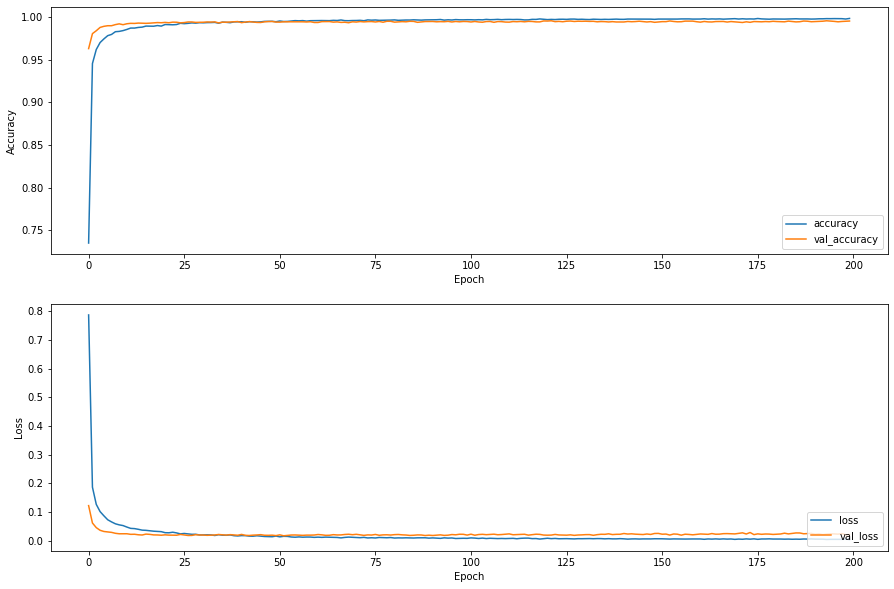

In [29]:
#Plot train/validation loss vs epoch

#### Fill in plot #####
plt.figure(figsize=(15,10))
#Plot accuracy vs epoch
plt.subplot(211)

plt.plot(history_dropout_hidden.history['acc'], label='accuracy')
plt.plot(history_dropout_hidden.history['val_acc'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
#### Fill in plot ####

#Plot loss vs epoch
plt.subplot(212)
plt.plot(history_dropout_hidden.history['loss'], label='loss')
plt.plot(history_dropout_hidden.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
#### Fill in plot ####


# Section 2- Autoencoders
<a id='autoencoders'></a>

## 2.1 Linear AE 
<a id='linear_ae'></a>

Fill in the model:
* Input: Flattened grayscale image to 28^2 = 784-dimensional vector.
* 1st hidden: 400 perceptrons.
* 2nd hidden: 200 perceptrons.
* 3rd hidden: 100 perceptrons.
* 4th hidden: 200 perceptrons.
* 5th hidden: 400 perceptrons.
* Output: 784 perceptrons.
<br>**Activations, bias, loss function, and optimizer are your choice.
<br> Train for 150 epochs**

In [40]:
#Reshape training and testing data
data_train_reshape_fcae = data_train.reshape(60000, 784)
data_test_reshape_fcae = data_test.reshape(10000, 784)

In [53]:
%%time
# Create autoencoder architecture
def deep_ae():
    model = tf.keras.models.Sequential()
    
    # Encoder
    
    #### Fill in the model ####
    model.add(layers.Dense(400, activation='relu', input_shape=(784,)))
    model.add(layers.Dense(200, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))
    
    # Decoder
    
    #### Fill in the model ####
    model.add(layers.Dense(200, activation='relu'))
    model.add(layers.Dense(400, activation='relu'))
    model.add(layers.Dense(784))
    
    return model

#Create deep autoencoder graph, compile it to use mean squared error loss and the adam optimizer, train the model, create predictions
deep_ae = deep_ae()
deep_ae.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam')
history_deep_ae = deep_ae.fit(data_train_reshape_fcae, data_train_reshape_fcae, 
                              validation_data=(data_test_reshape_fcae, data_test_reshape_fcae), 
                              epochs=150, batch_size=250, shuffle=True)
decoded_data = deep_ae.predict(data_test_reshape_fcae)

#Obtain encoder representation of data
get_hl = K.function([deep_ae.layers[0].input], [deep_ae.layers[2].output])
deep_ae_hl = get_hl([data_test_reshape_fcae])[0]

deep_ae.evaluate(data_test_reshape_fcae, data_test_reshape_fcae)

Train on 60000 samples, validate on 10000 samples
Epoch 1/150
60000/60000 [==============================] - 3s 44us/sample - loss: 0.0333 - val_loss: 0.0182
Epoch 2/150
60000/60000 [==============================] - 1s 25us/sample - loss: 0.0161 - val_loss: 0.0137
Epoch 3/150
60000/60000 [==============================] - 1s 24us/sample - loss: 0.0134 - val_loss: 0.0124
Epoch 4/150
60000/60000 [==============================] - 1s 23us/sample - loss: 0.0120 - val_loss: 0.0111
Epoch 5/150
60000/60000 [==============================] - 1s 23us/sample - loss: 0.0111 - val_loss: 0.0107
Epoch 6/150
60000/60000 [==============================] - 1s 24us/sample - loss: 0.0106 - val_loss: 0.0105
Epoch 7/150
60000/60000 [==============================] - 1s 24us/sample - loss: 0.0101 - val_loss: 0.0096
Epoch 8/150
60000/60000 [==============================] - 1s 24us/sample - loss: 0.0098 - val_loss: 0.0092
Epoch 9/150
60000/60000 [==============================] - 1s 24us/sample - loss: 0.00

Epoch 76/150
60000/60000 [==============================] - 1s 23us/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 77/150
60000/60000 [==============================] - 1s 24us/sample - loss: 0.0066 - val_loss: 0.0065
Epoch 78/150
60000/60000 [==============================] - 1s 24us/sample - loss: 0.0066 - val_loss: 0.0064
Epoch 79/150
60000/60000 [==============================] - 1s 23us/sample - loss: 0.0066 - val_loss: 0.0065
Epoch 80/150
60000/60000 [==============================] - 1s 24us/sample - loss: 0.0066 - val_loss: 0.0064
Epoch 81/150
60000/60000 [==============================] - 1s 25us/sample - loss: 0.0066 - val_loss: 0.0065
Epoch 82/150
60000/60000 [==============================] - 1s 24us/sample - loss: 0.0065 - val_loss: 0.0064
Epoch 83/150
60000/60000 [==============================] - 1s 23us/sample - loss: 0.0065 - val_loss: 0.0065
Epoch 84/150
60000/60000 [==============================] - 2s 25us/sample - loss: 0.0065 - val_loss: 0.0064
Epoch 85/150
60000/

In [54]:
# Information contained in history dict.
print(history_deep_ae.history.keys())

dict_keys(['loss', 'val_loss'])


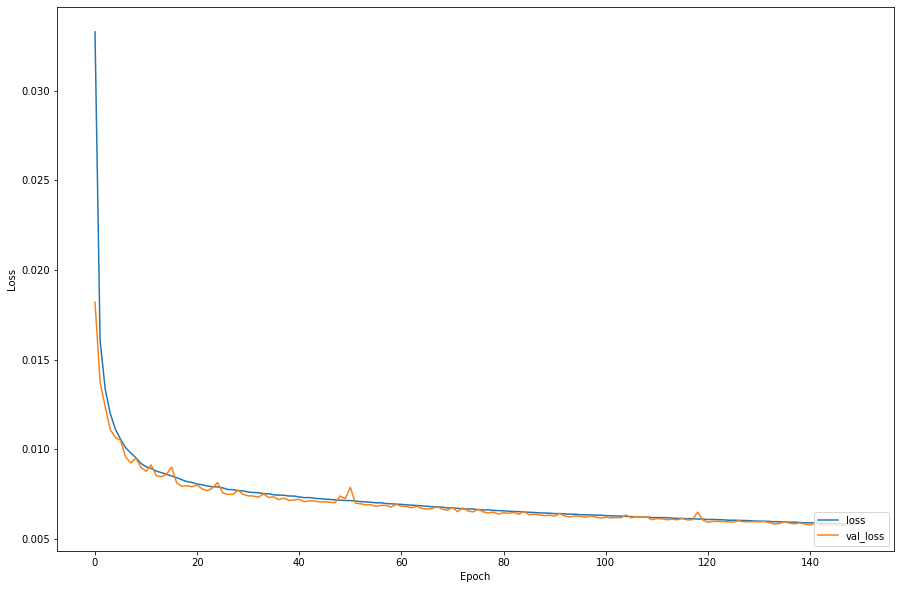

In [55]:
#Plot train/validation loss vs epoch

#### Fill in the plot ####

plt.figure(figsize=(15,10))
#Plot loss vs epoch
plt.subplot(111)
plt.plot(history_deep_ae.history['loss'], label='loss')
plt.plot(history_deep_ae.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
#### Fill in plot ####


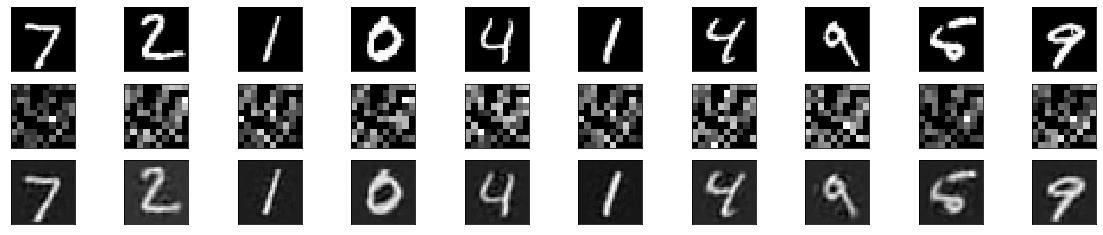

In [56]:
#Plot samples of 10 images, their hidden layer representations, and their reconstructions
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(data_test_reshape_fcae[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display hidden layer representation
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(deep_ae_hl[i].reshape(10, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(decoded_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 2.2 Convolutional AE 
<a id='convolutional_ae'></a>

Fill in the model:
* Input: 28x28x1 grayscale image.
* 1st hidden: 2D convolutional layer with 16 feature maps and 3x3 filters.
* 2nd hidden: A 2x2 maxpool layer.
* 3rd hidden: 2D convolutional layer with 8 feature maps and 3x3 filters.
* 4th hidden: A 2x2 maxpool layer.
* 5th hidden: 2D convolutional layer with 8 feature maps and 3x3 filters.
* 6th hidden: A 2x2 upsample layer.
* 7th hidden: 2D convolutional layer with 16 feature maps and 3x3 filters.
* 8th hidden: A 2x2 upsample layer.
* Output: A convolutional layer with a single feature map and 3x3 filters.
<br>**All experiments with dropout set at 30%.
<br>  Activations, dropout placement, bias , loss function, and optimizer are your choice.
<br>  Train for 200 epochs**

In [60]:
#Reshape data to account for grayscale channel in each image
data_train_reshape_cae = data_train.reshape(60000, 28, 28, 1)
data_test_reshape_cae = data_test.reshape(10000, 28, 28, 1)

In [90]:
%%time
#Create Convolutional AutoEncoder Architecture
def cae():
    model = models.Sequential()
    
    #Encoder
    #### Fill in model ####
    model.add(layers.Input(shape=(28, 28, 1)))
    
    model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    #Decoder
    #### Fill in model ####
    model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    
    model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    
    model.add(layers.Conv2D(1, (3, 3), activation='relu', padding='same'))
    
    return model

#Create deep autoencoder graph, compile it to use mean squared error loss and the adam optimizer, train the model, create predictions
conv_ae = cae()
print(conv_ae.summary())
conv_ae.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam')
history_conv_ae = conv_ae.fit(data_train_reshape_cae, data_train_reshape_cae, 
                              validation_data=(data_test_reshape_cae, data_test_reshape_cae), 
                              epochs=200, batch_size=250, shuffle=True)
decoded_data = conv_ae.predict(data_test_reshape_cae)

#Obtain encoder representation of data
get_hl = K.function([conv_ae.layers[0].input], [conv_ae.layers[3].output])
conv_ae_hl = get_hl([data_test_reshape_cae])[0]

conv_ae.evaluate(data_test_reshape_cae, data_test_reshape_cae)

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
up_sampling2d_20 (UpSampling (None, 14, 14, 8)       

Epoch 60/200
60000/60000 [==============================] - 9s 143us/sample - loss: 0.0051 - val_loss: 0.0037
Epoch 61/200
60000/60000 [==============================] - 9s 143us/sample - loss: 0.0051 - val_loss: 0.0037
Epoch 62/200
60000/60000 [==============================] - 8s 140us/sample - loss: 0.0051 - val_loss: 0.0037
Epoch 63/200
60000/60000 [==============================] - 8s 140us/sample - loss: 0.0051 - val_loss: 0.0037
Epoch 64/200
60000/60000 [==============================] - 8s 141us/sample - loss: 0.0051 - val_loss: 0.0037
Epoch 65/200
60000/60000 [==============================] - 8s 141us/sample - loss: 0.0051 - val_loss: 0.0037
Epoch 66/200
60000/60000 [==============================] - 9s 143us/sample - loss: 0.0051 - val_loss: 0.0037
Epoch 67/200
60000/60000 [==============================] - 9s 144us/sample - loss: 0.0051 - val_loss: 0.0037
Epoch 68/200
60000/60000 [==============================] - 9s 143us/sample - loss: 0.0051 - val_loss: 0.0036
Epoch 69/2

0.0035176812793822087

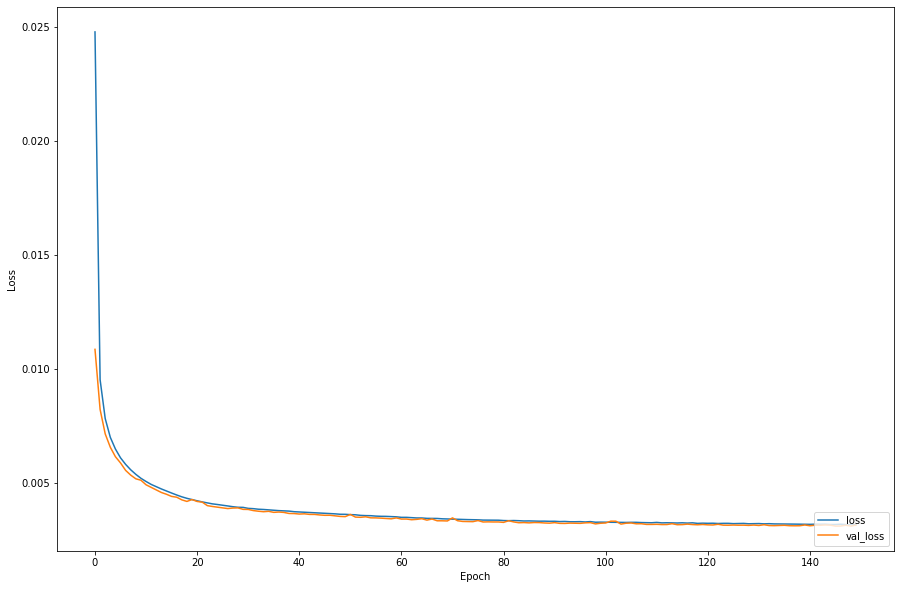

In [78]:
#Plot train/validation loss vs epoch

#### Fill in the plot ####

plt.figure(figsize=(15,10))
#Plot loss vs epoch
plt.subplot(111)
plt.plot(history_conv_ae.history['loss'], label='loss')
plt.plot(history_conv_ae.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
#### Fill in plot ####

<Figure size 432x288 with 0 Axes>

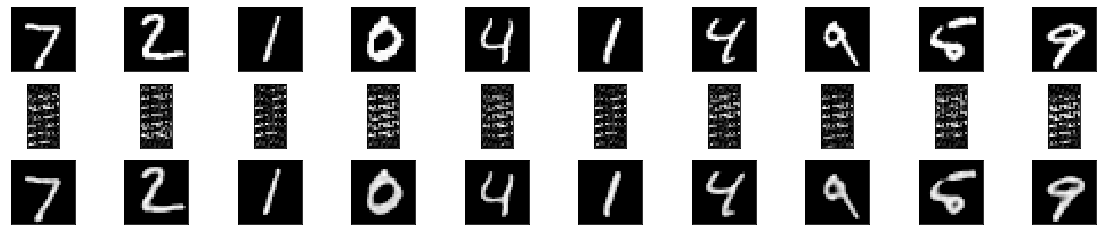

In [81]:
#Plot samples of 10 images, their hidden layer representations, and their reconstructions
n = 10  # how many digits we will display
plt.figure(3)
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(data_test_reshape_cae[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display hidden layer representation
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(conv_ae_hl[i].reshape(28, 14))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(decoded_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 2.3 Machine Anomaly Detection
<a id='anomaly_detection'></a>

Using the dataset provided **create the autoencdoer model** you deem necessary to achieve better than 75 true positives (TP = 75) where a true instance is an anomaly.
Or detect all 143 if you can! Although anomaly 
detection thresholds can be set arbitrarily and various metrics
are used depending on the problem, we will set ours at 2 
standard deviations from the mean of "normal" data to judge TP's. Use the code provided at the bottom for calculating true positives and histogramming. 

In [1]:
#### Restart your kernal and run from here to clear some memory
import tensorflow as tf
tf.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

tf.keras.backend.set_floatx('float64')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import sys
from os import listdir
from os.path import isfile, join

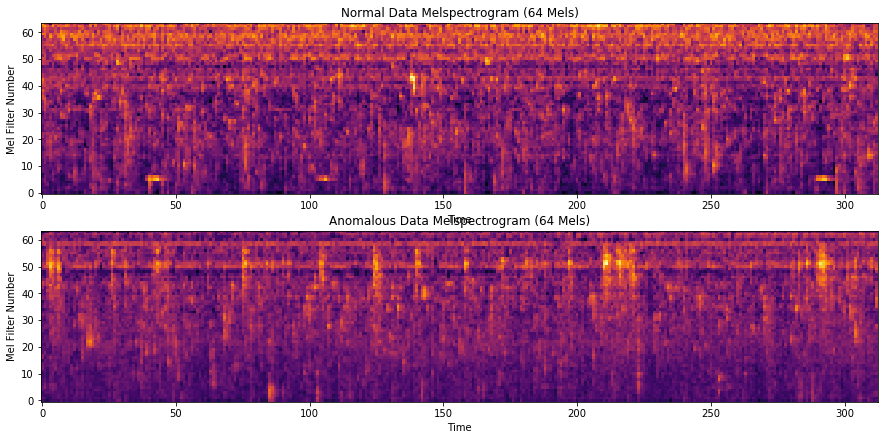

In [2]:
#### Load melspectrograms
ex_norm  = np.load('./ex_normalspec.npy')
ex_anom = np.load('./ex_abnormspec.npy')

plt.figure(figsize=(15,7))
plt.subplot(211)
plt.imshow(ex_norm[0,::-1], origin='lower', cmap='inferno')
plt.xlabel('Time')
plt.ylabel('Mel Filter Number')
plt.title('Normal Data Melspectrogram (64 Mels)') 

plt.subplot(212)
plt.imshow(ex_anom[0,::-1], origin='lower', cmap='inferno')
plt.xlabel('Time')
plt.ylabel('Mel Filter Number')
plt.title('Anomalous Data Melspectrogram (64 Mels)') 
plt.show()

In [27]:
# Create your own Baseline autoencoder
# Model name is fixed for use by later code
autoencoderBASE = tf.keras.models.Sequential([
   #### Fill in your model #####
    layers.Input(shape=(64, 316, 8)),
    
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Dropout(0.3),
    
    layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    #Decoder
    #### Fill in model ####
    
    layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    
    layers.Conv2D(8, (3, 3), activation='relu', padding='same')
])

In [35]:
autoencoderBASE.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 64, 316, 16)       1168      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 158, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 158, 16)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 158, 8)        1160      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 79, 8)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 79, 8)         584       
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 32, 158, 8)       

In [37]:
# Load data
normal_data  = np.load('./training_data.npy')
anomaly_data = np.load('./test_data.npy')

In [39]:
padding = ((0, 0), (0, 0), (0, 0), (1, 2))
normal_data = np.pad(normal_data, pad_width=padding, mode='constant', constant_values=0).transpose((0, 2, 3, 1))
anomaly_data = np.pad(anomaly_data, pad_width=padding, mode='constant', constant_values=0).transpose((0, 2, 3, 1))

In [40]:
x_train, x_valid = train_test_split(normal_data, test_size=0.2, random_state=42)
test = anomaly_data

In [8]:
x_train = tf.keras.utils.normalize(x_train)
x_valid = tf.keras.utils.normalize(x_valid)
test = tf.keras.utils.normalize(test)

In [41]:
%%time
#### General steps to follow
# Set up the data (reshape, scale, etc...
# Initialize a loss function
# Compile a model
# Train a model


#Create deep autoencoder graph, compile it to use mean squared error loss and the adam optimizer, train the model, create predictions
print(autoencoderBASE.summary())
lossMSE = tf.keras.losses.MeanSquaredError()
autoencoderBASE.compile(loss=lossMSE, optimizer='adam')

history_conv_ae = autoencoderBASE.fit(x_train, x_train,
                                      validation_data=(x_valid, x_valid),
                                      epochs=200, shuffle=True)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 64, 316, 16)       1168      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 158, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 158, 16)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 158, 8)        1160      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 79, 8)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 79, 8)         584       
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 32, 158, 8)       

800/800 [==============================] - 9s 11ms/sample - loss: 6.0323e-04 - val_loss: 5.7508e-04
Epoch 131/200
800/800 [==============================] - 8s 11ms/sample - loss: 6.0225e-04 - val_loss: 5.7513e-04
Epoch 132/200
800/800 [==============================] - 8s 11ms/sample - loss: 6.0143e-04 - val_loss: 5.7543e-04
Epoch 133/200
800/800 [==============================] - 8s 10ms/sample - loss: 6.0171e-04 - val_loss: 5.7357e-04
Epoch 134/200
800/800 [==============================] - 8s 10ms/sample - loss: 6.0069e-04 - val_loss: 5.7340e-04
Epoch 135/200
800/800 [==============================] - 8s 10ms/sample - loss: 6.0116e-04 - val_loss: 5.7406e-04
Epoch 136/200
800/800 [==============================] - 8s 10ms/sample - loss: 5.9973e-04 - val_loss: 5.7243e-04
Epoch 137/200
800/800 [==============================] - 8s 10ms/sample - loss: 5.9993e-04 - val_loss: 5.7191e-04
Epoch 138/200
800/800 [==============================] - 8s 10ms/sample - loss: 5.9886e-04 - val_loss:

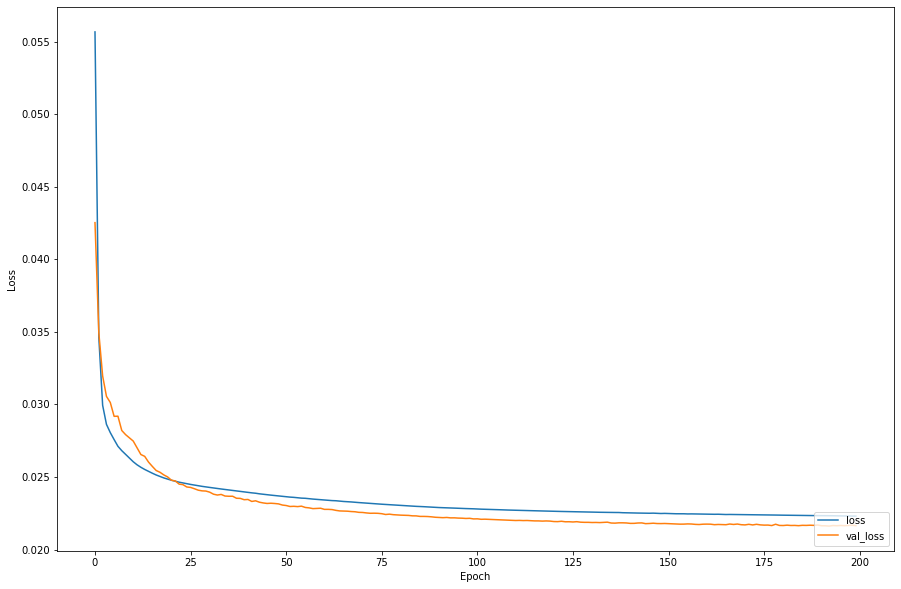

In [16]:
# Plot loss versus epoch.

plt.figure(figsize=(15,10))
#Plot loss vs epoch
plt.subplot(111)
plt.plot(history_conv_ae.history['loss'], label='loss')
plt.plot(history_conv_ae.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [43]:
x_train = x_train.reshape(-1, 1, 64, 316, 8)
x_valid = x_valid.reshape(-1, 1, 64, 316, 8)
test = test.reshape(-1, 1, 64, 316, 8)

The mean of normal data is 0.0219        and standard deviation is 0.0081


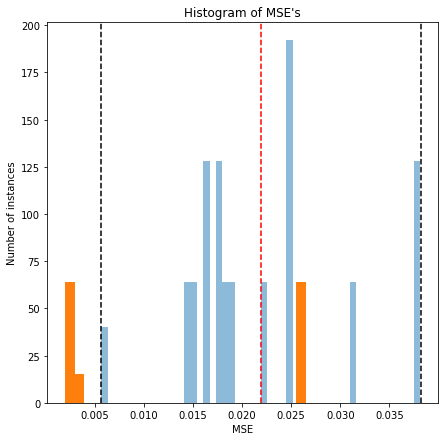

In [14]:
######### This code should remain untouched or autograder will 
######### give zero points.
#### Feed your data through to get mean and std
#### If you did not use a validation set then only use
#### your training data. Concatenating is therefore un-needed.
loss_list = []
# Combine train and validation data and get MSE's
dataset = (tf.data.Dataset.from_tensor_slices(np.concatenate((x_train,x_valid))))
for i, batch in dataset.enumerate():
    ae_predictions = autoencoderBASE(batch).numpy()
    loss_list.append(lossMSE(batch, ae_predictions).numpy())
# Feed the anomaly data through to get its MSE's
anom_list = []
anomset = (tf.data.Dataset.from_tensor_slices(test))
for i, batch in anomset.enumerate():
    ae_predictions = autoencoderBASE(batch).numpy()
    anom_list.append(lossMSE(batch, ae_predictions).numpy())
    
normal_data_MSEs = np.array(loss_list)
abnormal_data_MSEs = np.array(anom_list)
######## Code for presenting answer to Question 2.3 ################## 
threshold = 2.0
mean = normal_data_MSEs.mean()
std = normal_data_MSEs.std()
print(f'The mean of normal data is {mean:.4f}\
        and standard deviation is {std:.4f}')
upperbound = mean+threshold*std
lowerbound = mean-threshold*std
plt.figure(figsize=(7,7))
plt.title('Histogram of MSE\'s')
plt.hist(normal_data_MSEs, bins=50, alpha=0.5)
plt.hist(abnormal_data_MSEs, bins=25, alpha=1.0)
plt.axvline(mean,ls='--', c='r')
plt.axvline(lowerbound, ls='--',c='k')
plt.axvline(upperbound, ls='--',c='k')
plt.xlabel('MSE')
plt.ylabel('Number of instances')
plt.show()

In [15]:
tp_count = np.sum(abnormal_data_MSEs >= upperbound) +\
           np.sum(abnormal_data_MSEs <= lowerbound)
tn_count = anomaly_data.shape[0] - tp_count
fp_count = np.sum(normal_data_MSEs >= upperbound)+\
           np.sum(normal_data_MSEs <= lowerbound)
fn_count = 1000 - fp_count

print(f'TP {tp_count} \t TN {tn_count}')
print(f'FP {fp_count} \t FN {fn_count}')

TP 79 	 TN 64
FP 0 	 FN 1000
